In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from lazypredict.Supervised import LazyRegressor


In [2]:

df = pd.read_csv("bike-sharing-dataset.csv")

In [3]:
df.head()

,date_time,holiday,workingday,weather,temp,atemp,hum,windspeed,users,month,hour,weekday
0,2011-01-01 00:00:00,0.00,0.00,clear,9.84,14.39,81.00,0.00,16.00,1,0,5
1,2011-01-01 01:00:00,0.00,0.00,clear,9.02,13.63,80.00,0.00,40.00,1,1,5
2,2011-01-01 02:00:00,0.00,0.00,clear,9.02,13.63,80.00,0.00,32.00,1,2,5
3,2011-01-01 03:00:00,0.00,0.00,clear,9.84,14.39,75.00,0.00,13.00,1,3,5
4,2011-01-01 04:00:00,0.00,0.00,clear,9.84,14.39,75.00,0.00,1.00,1,4,5


In [4]:
df['date_time'] = pd.to_datetime(df['date_time'])


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date_time   17544 non-null  datetime64[ns]
 1   holiday     17544 non-null  float64       
 2   workingday  17544 non-null  float64       
 3   weather     17544 non-null  object        
 4   temp        17544 non-null  float64       
 5   atemp       17544 non-null  float64       
 6   hum         17544 non-null  float64       
 7   windspeed   17544 non-null  float64       
 8   users       17544 non-null  float64       
 9   month       17544 non-null  int64         
 10  hour        17544 non-null  int64         
 11  weekday     17544 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(3), object(1)
memory usage: 1.6+ MB


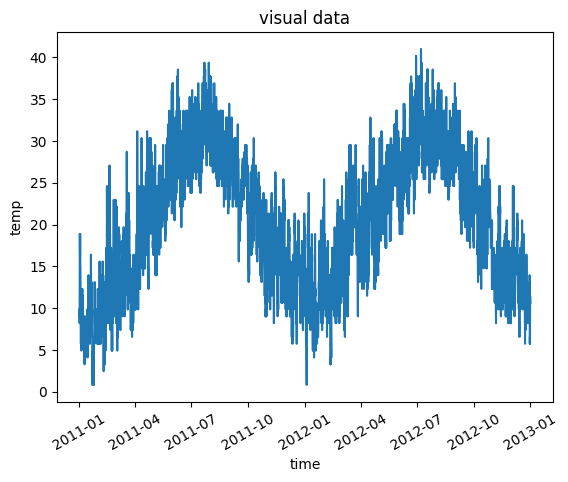

In [6]:
plt.plot(df.date_time, df.temp)
plt.xlabel("time")
plt.ylabel("temp")
plt.title("visual data")
plt.xticks(rotation = 30)
plt.show()

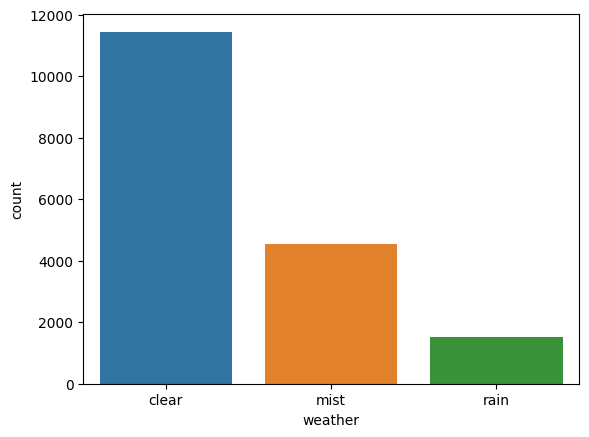

In [7]:
sns.countplot(x = 'weather', data  = df)
plt.xlabel("weather")
plt.ylabel("count")
plt.show()

### create data

In [8]:
def create_data(data, window_size):
     i = 1
     while i < window_size:
          data['temp_{}'.format(i)] = data['temp'].shift(-i)
          i += 1
     data['target'] = data['temp'].shift(-i)

     data = data.dropna(axis= 0)
     return data

In [9]:
window_size = 4
df = create_data(df, window_size)

In [10]:
df.head()

,date_time,holiday,workingday,weather,temp,atemp,hum,windspeed,users,month,hour,weekday,temp_1,temp_2,temp_3,target
0,2011-01-01 00:00:00,0.00,0.00,clear,9.84,14.39,81.00,0.00,16.00,1,0,5,9.02,9.02,9.84,9.84
1,2011-01-01 01:00:00,0.00,0.00,clear,9.02,13.63,80.00,0.00,40.00,1,1,5,9.02,9.84,9.84,9.84
2,2011-01-01 02:00:00,0.00,0.00,clear,9.02,13.63,80.00,0.00,32.00,1,2,5,9.84,9.84,9.84,9.02
3,2011-01-01 03:00:00,0.00,0.00,clear,9.84,14.39,75.00,0.00,13.00,1,3,5,9.84,9.84,9.02,8.20
4,2011-01-01 04:00:00,0.00,0.00,clear,9.84,14.39,75.00,0.00,1.00,1,4,5,9.84,9.02,8.20,9.84


### train test split

In [11]:
x = df.drop(['date_time','target'], axis = 1)
y = df['target']

In [12]:
x.head()

,holiday,workingday,weather,temp,atemp,hum,windspeed,users,month,hour,weekday,temp_1,temp_2,temp_3
0,0.00,0.00,clear,9.84,14.39,81.00,0.00,16.00,1,0,5,9.02,9.02,9.84
1,0.00,0.00,clear,9.02,13.63,80.00,0.00,40.00,1,1,5,9.02,9.84,9.84
2,0.00,0.00,clear,9.02,13.63,80.00,0.00,32.00,1,2,5,9.84,9.84,9.84
3,0.00,0.00,clear,9.84,14.39,75.00,0.00,13.00,1,3,5,9.84,9.84,9.02
4,0.00,0.00,clear,9.84,14.39,75.00,0.00,1.00,1,4,5,9.84,9.02,8.20


In [13]:
ratio = 0.8
x_train = x[:int(len(x)*0.8)]
y_train = y[:int(len(x)*0.8)]

x_test = x[int(len(x)*0.8):]
y_test = y[int(len(x)*0.8):]


In [14]:
x_train.shape

(14032, 14)

In [15]:
y_train.shape

(14032,)

In [16]:
num_features = Pipeline(steps=[
    ("scale", StandardScaler())
])
weather_values = df['weather'].unique()

ord_features = Pipeline(steps=[
    ("encoder", OrdinalEncoder(categories=[weather_values]))
])
preprocessor = ColumnTransformer(transformers=[
    ("num_features", num_features, ['holiday', 'workingday','temp', 'atemp','hum','windspeed','users','month', 'hour','weekday','temp_1','temp_2','temp_3']),
    ("ord_features", ord_features, ['weather'])
])

In [17]:
reg = Pipeline(steps=[
    ('processor', preprocessor),
    ("model", LinearRegression())
])


In [18]:
reg.fit(x_train, y_train)

Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('num_features',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['holiday', 'workingday',
                                                   'temp', 'atemp', 'hum',
                                                   'windspeed', 'users',
                                                   'month', 'hour', 'weekday',
                                                   'temp_1', 'temp_2',
                                                   'temp_3']),
                                                 ('ord_features',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(categories=[array(['clear', 'mist', 'rain'], dtype=object)]))]),
                                                  ['weather'])])),
                ('model', LinearRegression())])

In [19]:
y_pred = reg.predict(x_test)

In [20]:
print("r2", r2_score(y_test, y_pred))
print("mae", mean_absolute_error(y_test, y_pred))
print("mse", mean_squared_error(y_test, y_pred))

r2 0.9853650179551513
mae 0.5940066676120038
r2 0.7024601658821586


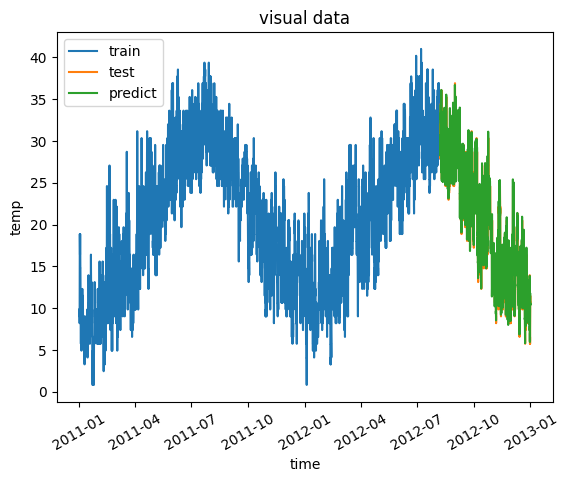

In [21]:
plt.plot(df['date_time'][:int(len(df)*0.8)], df['temp'][:int(len(df)*0.8)], label = "train")
plt.plot(df['date_time'][int(len(df)*0.8):], df['temp'][int(len(df)*0.8):], label = "test")
plt.plot(df['date_time'][int(len(df)*0.8):], y_pred, label = "predict")
plt.xlabel("time")
plt.ylabel("temp")
plt.title("visual data")
plt.xticks(rotation = 30)
plt.legend()
plt.show()

In [22]:
pram = {
    "model__fit_intercept" : [True, False],
    "model__copy_X" : [True, False],
}

In [23]:
grid_pred = GridSearchCV(reg, param_grid=pram, n_jobs= -1, verbose= 1, scoring='r2')


In [24]:
grid_pred

GridSearchCV(estimator=Pipeline(steps=[('processor',
                                        ColumnTransformer(transformers=[('num_features',
                                                                         Pipeline(steps=[('scale',
                                                                                          StandardScaler())]),
                                                                         ['holiday',
                                                                          'workingday',
                                                                          'temp',
                                                                          'atemp',
                                                                          'hum',
                                                                          'windspeed',
                                                                          'users',
                                                                          'month',
                                                                          'hour',
                                                                          'weekday',
                                                                          'temp_1',
                                                                          'temp_2',
                                                                          'temp_3']),
                                                                        ('ord_features',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OrdinalEncoder(categories=[array(['clear', 'mist', 'rain'], dtype=object)]))]),
                                                                         ['weather'])])),
                                       ('model', LinearRegression())]),
             n_jobs=-1,
             param_grid={'model__copy_X': [True, False],
                         'model__fit_intercept': [True, False]},
             scoring='r2', verbose=1)

In [457]:
grid_pred.fit(x_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=Pipeline(steps=[('processor',
                                        ColumnTransformer(transformers=[('num_features',
                                                                         Pipeline(steps=[('scale',
                                                                                          StandardScaler())]),
                                                                         ['holiday',
                                                                          'workingday',
                                                                          'temp',
                                                                          'atemp',
                                                                          'hum',
                                                                          'windspeed',
                                                                          'users',
                                                                          'month',
                                                                          'hour',
                                                                          'weekday',
                                                                          'temp_1',
                                                                          'temp_2',
                                                                          'temp_3']),
                                                                        ('ord_features',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OrdinalEncoder(categories=[array(['clear', 'mist', 'rain'], dtype=object)]))]),
                                                                         ['weather'])])),
                                       ('model', LinearRegression())]),
             n_jobs=-1,
             param_grid={'model__copy_X': [True, False],
                         'model__fit_intercept': [True, False]},
             scoring='r2', verbose=1)

In [461]:
print(grid_pred.best_score_)

0.9707179659455673


In [462]:
print(grid_pred.best_params_)

{'model__copy_X': True, 'model__fit_intercept': True}


In [463]:
print(grid_pred.scorer_)

make_scorer(r2_score)


In [467]:
process_lazy = Pipeline(steps=[
    ("preprocess", preprocessor)
])

In [468]:
x_train = process_lazy.fit_transform(x_train)
x_test = process_lazy.transform(x_test)

In [ ]:
reg_lazy_pre = LazyRegressor(verbose= 0, ignore_warnings= False, custom_metric= None)
models, predictions = reg_lazy_pre.fit(x_train, x_test, y_train, y_test)